In [1]:
!git clone https://github.com/juhitiwari/BrainMRI.git

Cloning into 'BrainMRI'...
remote: Enumerating objects: 2361, done.
remote: Counting objects: 100% (2361/2361), done.
remote: Compressing objects: 100% (2352/2352), done.
remote: Total 2361 (delta 19), reused 2341 (delta 8), pack-reused 0
Receiving objects: 100% (2361/2361), 43.19 MiB | 35.08 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [2]:
%cd BrainMRI/

/content/BrainMRI


In [4]:
!pip install import-ipynb


  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=578e4d1bb94dbe68b060c3d63a5b775c289f9757365087deb5732bba104d9c85
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import time
from os import listdir
import import_ipynb
from my_model import build_model

%matplotlib inline

importing Jupyter notebook from my_model.ipynb


In [0]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

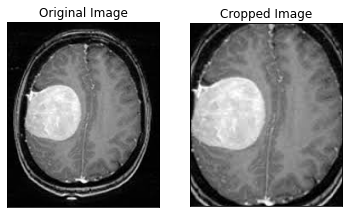

In [7]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [0]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            print(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [9]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

augmented data/yes/aug_Y246_0_4965.jpg
augmented data/yes/aug_Y153_0_3427.jpg
augmented data/yes/aug_Y186_0_9826.jpg
augmented data/yes/aug_Y116_0_1235.jpg
augmented data/yes/aug_Y248_0_8271.jpg
augmented data/yes/aug_Y4_0_2704.jpg
augmented data/yes/aug_Y116_0_4117.jpg
augmented data/yes/aug_Y146_0_705.jpg
augmented data/yes/aug_Y248_0_6284.jpg
augmented data/yes/aug_Y31_0_9059.jpg
augmented data/yes/aug_Y78_0_3850.jpg
augmented data/yes/aug_Y11_0_7489.jpg
augmented data/yes/aug_Y167_0_6072.jpg
augmented data/yes/aug_Y75_0_1073.jpg
augmented data/yes/aug_Y12_0_6162.jpg
augmented data/yes/aug_Y253_0_6542.jpg
augmented data/yes/aug_Y28_0_8275.jpg
augmented data/yes/aug_Y77_0_7917.jpg
augmented data/yes/aug_Y109_0_8166.jpg
augmented data/yes/aug_Y73_0_8338.jpg
augmented data/yes/aug_Y81_0_1494.jpg
augmented data/yes/aug_Y195_0_661.jpg
augmented data/yes/aug_Y195_0_1949.jpg
augmented data/yes/aug_Y105_0_1041.jpg
augmented data/yes/aug_Y157_0_753.jpg
augmented data/yes/aug_Y79_0_1376.jpg
a

In [0]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

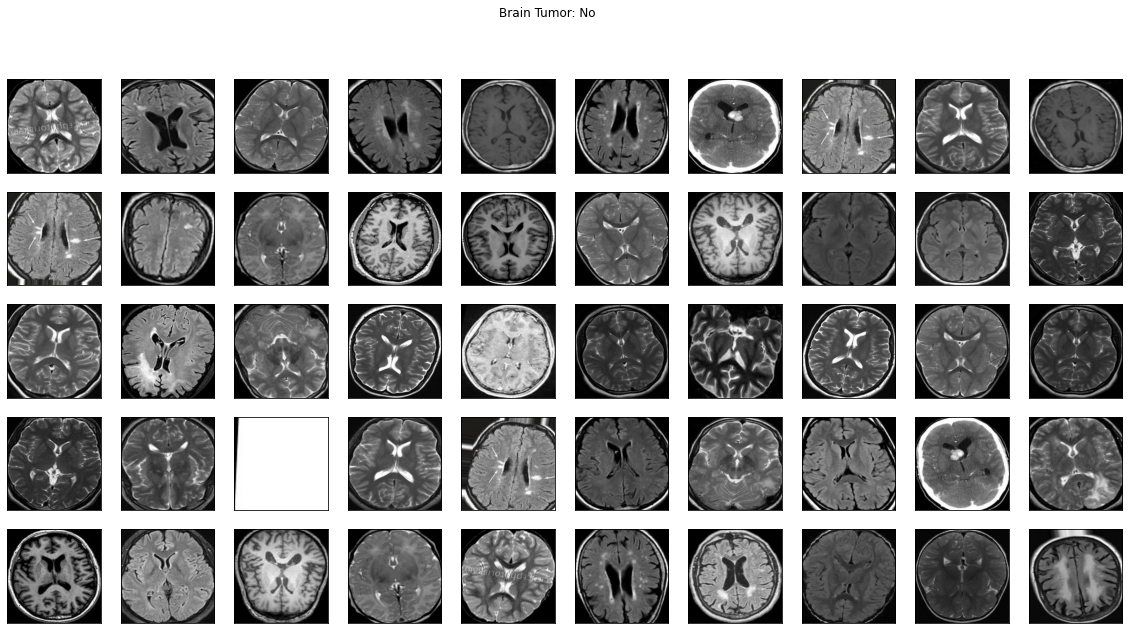

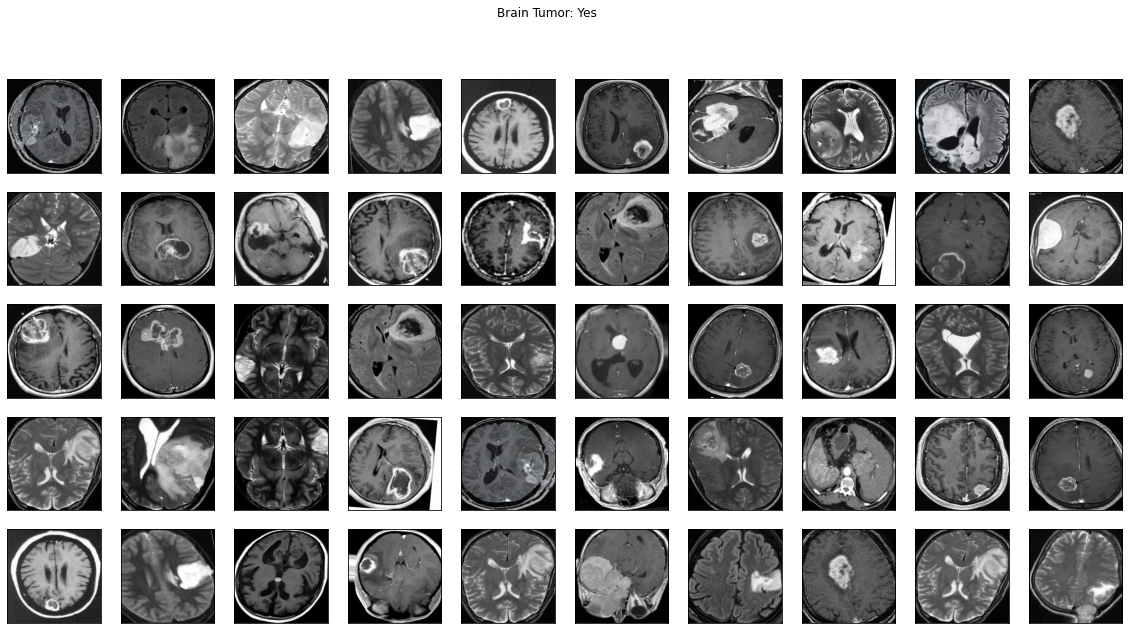

In [11]:
plot_sample_images(X, y)

In [0]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)


In [14]:


# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes ='yes' 
augmented_no = 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

Xm, ym= load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

yes/Y75.JPG
yes/Y27.jpg
yes/Y82.jpg
yes/Y157.JPG
yes/Y11.jpg
yes/Y65.JPG
yes/Y187.jpg
yes/Y116.JPG
yes/Y89.JPG
yes/Y77.jpg
yes/Y102.jpg
yes/Y98.JPG
yes/Y246.JPG
yes/Y115.JPG
yes/Y7.jpg
yes/Y14.jpg
yes/Y45.JPG
yes/Y34.jpg
yes/Y192.JPG
yes/Y42.jpg
yes/Y38.jpg
yes/Y56.jpg
yes/Y81.jpg
yes/Y46.jpg
yes/Y70.jpg
yes/Y92.jpg
yes/Y242.JPG
yes/Y101.jpg
yes/Y112.JPG
yes/Y180.jpg
yes/Y86.JPG
yes/Y147.JPG
yes/Y169.jpg
yes/Y16.JPG
yes/Y117.JPG
yes/Y170.JPG
yes/Y148.JPG
yes/Y183.jpg
yes/Y160.JPG
yes/Y103.jpg
yes/Y54.jpg
yes/Y108.jpg
yes/Y3.jpg
yes/Y248.JPG
yes/Y185.jpg
yes/Y23.JPG
yes/Y15.jpg
yes/Y259.JPG
yes/Y50.JPG
yes/Y105.jpg
yes/Y100.JPG
yes/Y69.jpg
yes/Y255.JPG
yes/Y60.jpg
yes/Y146.JPG
yes/Y113.JPG
yes/Y96.jpg
yes/Y32.jpg
yes/Y52.jpg
yes/Y28.jpg
yes/Y79.jpg
yes/Y18.JPG
yes/Y164.JPG
yes/Y13.jpg
yes/Y250.jpg
yes/Y2.jpg
yes/Y256.JPG
yes/Y73.jpg
yes/Y166.JPG
yes/Y44.JPG
yes/Y20.jpg
yes/Y49.JPG
yes/Y17.jpg
yes/Y193.JPG
yes/Y58.JPG
yes/Y258.JPG
yes/Y167.JPG
yes/Y19.JPG
yes/Y254.jpg
yes/Y36.JPG
yes/Y22

In [0]:
X_trainm, y_trainm, X_valm, y_valm, X_testm, y_testm = split_data(Xm, ym, test_size=0.3)


In [0]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
modelbp = build_model(IMG_SHAPE)

In [45]:
modelbp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelbp.fit(x=X_trainm, y=y_trainm, batch_size=32, epochs=3, validation_data=(X_valm, y_valm))

Epoch 1/3
6/6 [==============================] - 13s 2s/step - loss: 1.7218 - accuracy: 0.5706 - val_loss: 0.5606 - val_accuracy: 0.6316
Epoch 2/3
6/6 [==============================] - 12s 2s/step - loss: 0.8574 - accuracy: 0.5650 - val_loss: 0.5615 - val_accuracy: 0.6316
Epoch 3/3
6/6 [==============================] - 12s 2s/step - loss: 0.5908 - accuracy: 0.7006 - val_loss: 0.5632 - val_accuracy: 0.6316


loss
accuracy
val_loss
val_accuracy


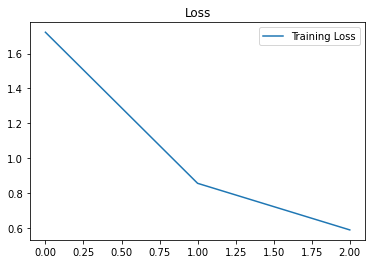

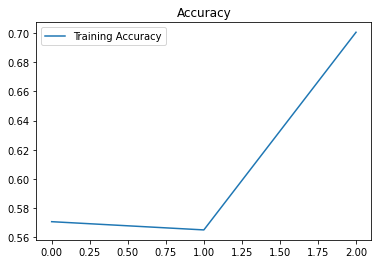

2/2 [==============================] - 0s 68ms/step - loss: 0.6800 - accuracy: 0.5263
Test Accuracy = 0.679953396320343


In [46]:
history = modelbp.history.history
for key in history.keys():
    print(key)
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.savefig("bploss.png")
    files.download("bploss.png") 
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.savefig("bpacc.png")
    files.download("bpacc.png") 
    plt.title('Accuracy')
    plt.legend()
    plt.show()
plot_metrics(history)
acc, loss = modelbp.evaluate(x=X_testm, y=y_testm)
print (f"Test Accuracy = {acc}")

In [0]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)


In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=4, validation_data=(X_val, y_val))

Epoch 1/4
46/46 [==============================] - 119s 3s/step - loss: 0.7076 - accuracy: 0.6422 - val_loss: 0.6472 - val_accuracy: 0.6806
Epoch 2/4
46/46 [==============================] - 119s 3s/step - loss: 0.6004 - accuracy: 0.6955 - val_loss: 0.6586 - val_accuracy: 0.5419
Epoch 3/4
46/46 [==============================] - 119s 3s/step - loss: 0.4479 - accuracy: 0.7827 - val_loss: 0.5633 - val_accuracy: 0.7065
Epoch 4/4
46/46 [==============================] - 119s 3s/step - loss: 0.3624 - accuracy: 0.8498 - val_loss: 0.5103 - val_accuracy: 0.7613


loss
accuracy
val_loss
val_accuracy


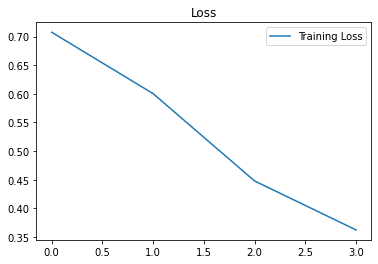

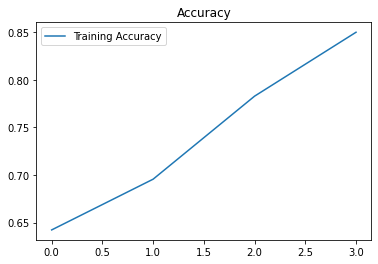

2/2 [==============================] - 0s 70ms/step - loss: 0.6440 - accuracy: 0.6053
Test Accuracy = 0.6439789533615112


In [37]:
history = model.history.history
for key in history.keys():
    print(key)
from google.colab import files
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.savefig("psobploss.png")
    files.download("psobploss.png") 
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.savefig("psobpacc.png")
    files.download("psobpacc.png") 
    plt.title('Accuracy')
    plt.legend()
    plt.show()
plot_metrics(history)
acc, loss = modelbp.evaluate(x=X_testm, y=y_testm)
print (f"Test Accuracy = {acc}")

In [0]:
#@title Visualization
def plot_confusion_matrix_bp():
  from mlxtend.plotting import plot_confusion_matrix
  import matplotlib.pyplot as plt
  import numpy as np

  binary1 = np.array([[68, 33],
                    [10, 89]])

  fig, ax = plot_confusion_matrix(conf_mat=binary1)
  plt.show()
  plt.savefig("bpcm.png")
  files.download("bpcm.png") 

def plot_confusion_matrix_psobp():
  from mlxtend.plotting import plot_confusion_matrix
  import matplotlib.pyplot as plt
  import numpy as np

  binary1 = np.array([[72, 24],
                    [6, 98]])

  fig, ax = plot_confusion_matrix(conf_mat=binary1)
  plt.show()
  plt.savefig("psobpcm.png")
  files.download("psobpcm.png") 



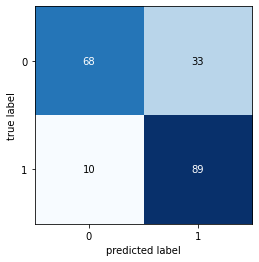

<Figure size 432x288 with 0 Axes>

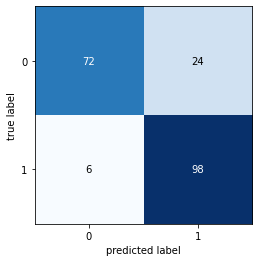

<Figure size 432x288 with 0 Axes>

In [43]:
plot_confusion_matrix_bp()
plot_confusion_matrix_psobp()
